# Lab7: Text Analysis

In [ ]:
import re
import pandas as pd
import numpy as np
from nltk.stem import SnowballStemmer

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import seaborn as sns    
import matplotlib.pyplot as plt
%matplotlib inline 

## Problem 1.1 - Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
emails = pd.read_csv('/content/drive/MyDrive/emails.csv')
n = emails.count()[0]
emails.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


**Q1. How many emails are in the dataset?**

5728 emails are present in the dataset

In [ ]:
emails.describe()

,spam
count,5728.000000
mean,0.238827
std,0.426404
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


**Q2. How many of the emails are spam?**

There are 1368 spam emails, roughly 24% of the dataset is spam and rest are ham datapoints, as seen by the mean, as well as the countplot of the spam column

The dataset has 1368 spam emails out of 5728, roughly 23.88%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


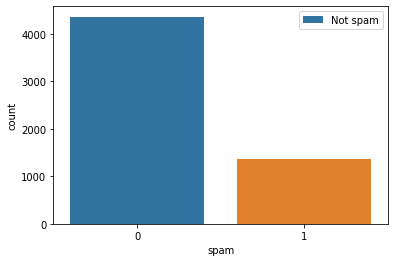

In [ ]:
sns.countplot(emails['spam'])
plt.legend(['Not spam', 'Spam'])
nspam=emails.query('spam == 1').count()[0]
print(f"The dataset has {nspam} spam emails out of {emails.count()[0]}, roughly 23.88%")

There are total 2 columns, text is of string type and spam is of int type each containing the content of the email and it's status, if it's spam or ham

In [ ]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


**Q3. Which word appears at the beginning of every email in the dataset?**

Subject

In [ ]:
emails['text']

0       Subject: naturally irresistible your corporate...
1       Subject: the stock trading gunslinger  fanny i...
2       Subject: unbelievable new homes made easy  im ...
3       Subject: 4 color printing special  request add...
4       Subject: do not have money , get software cds ...
                              ...                        
5723    Subject: re : research and development charges...
5724    Subject: re : receipts from visit  jim ,  than...
5725    Subject: re : enron case study update  wow ! a...
5726    Subject: re : interest  david ,  please , call...
5727    Subject: news : aurora 5 . 2 update  aurora ve...
Name: text, Length: 5728, dtype: object

In [ ]:
print(f"Checking if all the emails contain first word as `Subject:`")
emails[emails['text'].apply(lambda x: x.startswith('Subject:'))].count()[0]
print("We see that all the emails contain the word subject")

Checking if all the emails contain first word as `Subject:`
We see that all the emails contain the word subject


**Q4. Could a spam classifier potentially benefit from including the frequency of the word that appears in every email?**

**Current Hypothesis**

Since all emails have a subject, including the frequency of the word appearing in every email would not give us any useful information about the nature of the email/ it's contents that contain the spam, and should hence be removed

**No** : The word appears in every email so this variable would not help us differentiate spam from ham.

**Q5. How many characters are in the longest email in the dataset (where longest is measured in terms of the maximum number of characters)?**

43952

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


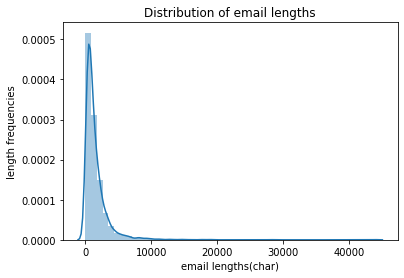

In [ ]:
subject_len = emails.apply(lambda x: len(x['text']), axis=1)
sns.distplot(subject_len)
plt.title('Distribution of email lengths')
plt.xlabel('email lengths(char)')
plt.ylabel('length frequencies')
plt.show()

In [ ]:
print(f'The maximum email length is {max(subject_len)}')

The maximum email length is 43952


## Problem 2.1 - Preparing the corpus

Before proceeding, we make changes to the original text column of the dataset:
* Remove all the punctutaions 
* Make our 'text' column into lowercase
* Remove the stopwords
* Apply Stemming on the corpus

### a. Remove Punctuations

In [ ]:
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
def fn(text):
    # Removing punctuations in stripped and lowercased string using regex
    return re.sub(r'[^\w\s]', '', text.strip()[8:].lower())

emails['text'] = emails['text'].apply(func=fn)
emails.head()

,text,spam
0,naturally irresistible your corporate identit...,1
1,the stock trading gunslinger fanny is merril...,1
2,unbelievable new homes made easy im wanting ...,1
3,4 color printing special request additional ...,1
4,do not have money get software cds from here...,1


In [ ]:
with open('/content/drive/MyDrive/stopwords.txt') as f:
    exec(f.read())
sw

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 "can't",
 'cannot',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 "s

### b. Remove Stopwords

In [ ]:
def remove_stopwords(text):
    temp = ''
    for word in text.split():
        if word not in sw:
            temp += (word+' ')
    return temp.strip()
emails['text']=emails['text'].apply(remove_stopwords)
emails.head()

,text,spam
0,naturally irresistible corporate identity lt r...,1
1,stock trading gunslinger fanny merrill muzo co...,1
2,unbelievable new homes made easy im wanting sh...,1
3,4 color printing special request additional in...,1
4,money get software cds software compatibility ...,1


### c. Stemming

In [ ]:
snowball = SnowballStemmer(language='english')
def stem(text):
    temp = ''
    for word in text.split():
        temp += ( snowball.stem(word) + ' ' )
    return temp.strip()
emails['text']=emails['text'].apply(stem) # Apply stemming to the text
emails.head()

,text,spam
0,natur irresist corpor ident lt realli hard rec...,1
1,stock trade gunsling fanni merril muzo colza a...,1
2,unbeliev new home made easi im want show homeo...,1
3,4 color print special request addit inform now...,1
4,money get softwar cds softwar compat ain t gre...,1


## Building DTM & corpus

In [ ]:
corpus = set()
for entry in emails['text']:
    for word in entry.split():
      corpus.add(word)
corpus = list(corpus)
m = len(corpus)
m

29301

In [ ]:
dtm = pd.DataFrame([[0 for i in range(m)] for _ in range(n)], columns = corpus)
for email in emails['text']:
  for word in email.split():
    dtm[word]=1
dtm['spam'] = emails['spam']
dtm.head()

,modal,egmcont,ok,optimum,balt,weak,flang,ceil,prostaff,8821652098236,...,skierown,meiner,hydrargyrum,cowhid,hoog,15177,bhushan,turbomachineri,jpicazo,wieloma
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


## Problem 3.1 – Building machine learning models

In [ ]:
X = dtm
y = np.array(emails['spam']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
model = DecisionTreeClassifier(criterion="gini")
model.fit(X_train, y_train)
model.score(X_test, y_test)

1.0